SMS Spam Detection

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    classification_report, roc_auc_score
)
from wordcloud import WordCloud
import re
import string
import joblib
import warnings
warnings.filterwarnings('ignore')

 Load Dataset

In [12]:

df = pd.read_csv(
    r"C:\Users\mdhar\Documents\ML project\Credit Card Transactions Fraud Detection Dataset\spam.csv",
    encoding='latin-1'
)
print("Shape:", df.shape)
print(df.head())


Shape: (5572, 5)
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


 Clean Dataset

In [13]:
df = df[['v1', 'v2']]
df.columns = ['label', 'message']
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})
print("\nLabel distribution:\n", df['label'].value_counts())



Label distribution:
 label
ham     4825
spam     747
Name: count, dtype: int64


Text Preprocessing

In [14]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_msg'] = df['message'].apply(clean_text)
df['msg_length'] = df['clean_msg'].apply(len)


Data Visualization

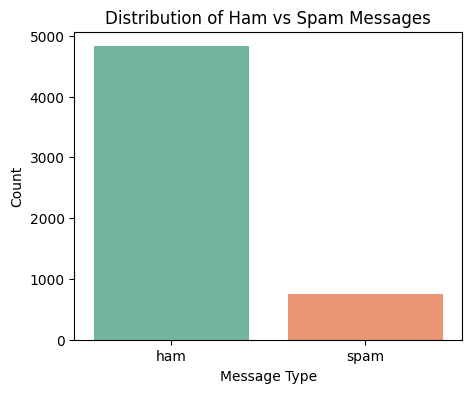

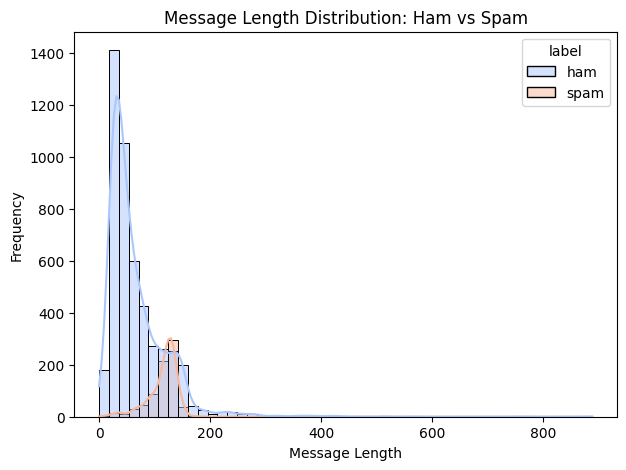

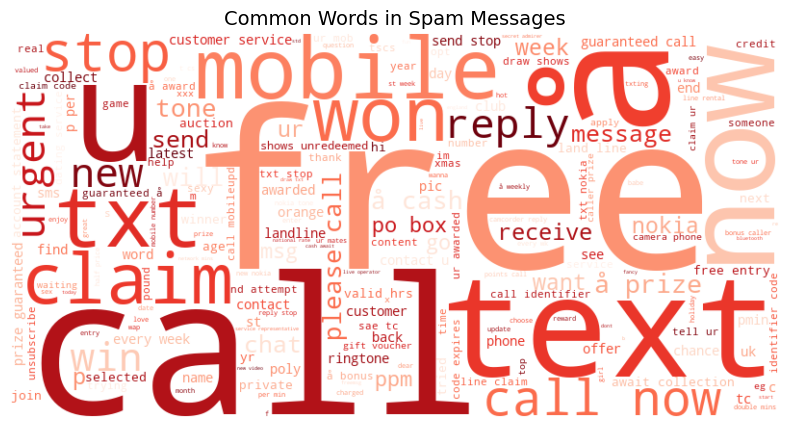

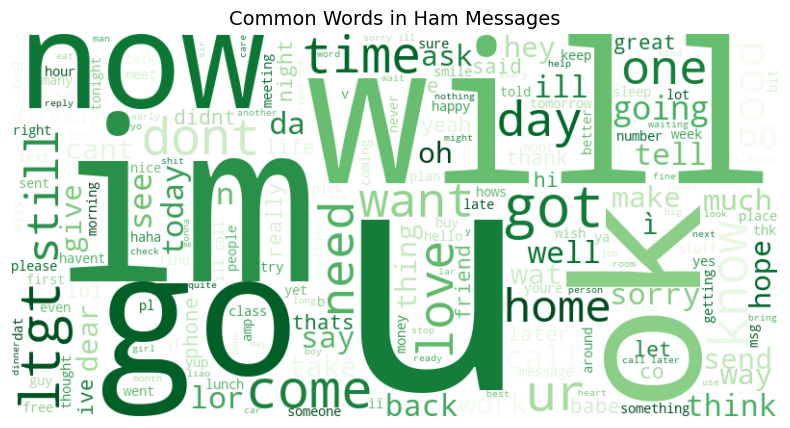

In [15]:
# (a) Spam vs Ham Count
plt.figure(figsize=(5,4))
sns.countplot(x='label', data=df, palette='Set2')
plt.title("Distribution of Ham vs Spam Messages")
plt.xlabel("Message Type")
plt.ylabel("Count")
plt.show()

# (b) Message Length Distribution
plt.figure(figsize=(7,5))
sns.histplot(data=df, x='msg_length', hue='label', bins=50, kde=True, palette='coolwarm')
plt.title("Message Length Distribution: Ham vs Spam")
plt.xlabel("Message Length")
plt.ylabel("Frequency")
plt.show()

# (c) WordCloud for Spam
spam_text = " ".join(df[df['label'] == 'spam']['clean_msg'])
ham_text = " ".join(df[df['label'] == 'ham']['clean_msg'])

spam_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(spam_text)
ham_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(ham_text)

plt.figure(figsize=(10,5))
plt.imshow(spam_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Spam Messages", fontsize=14)
plt.show()

plt.figure(figsize=(10,5))
plt.imshow(ham_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Ham Messages", fontsize=14)
plt.show()

Train-Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_msg'], df['label_num'],
    test_size=0.2, random_state=42, stratify=df['label_num']
)


Vectorization (TF-IDF)

In [17]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

Train Model (Logistic Regression)

In [18]:
model = LogisticRegression(max_iter=300)
print("\nTraining model...")
model.fit(X_train_tfidf, y_train)


Training model...


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,300
,multi_class,'deprecated'


 Evaluate Model


 Accuracy: 0.9623
 ROC-AUC Score: 0.9843

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       0.99      0.72      0.84       149

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



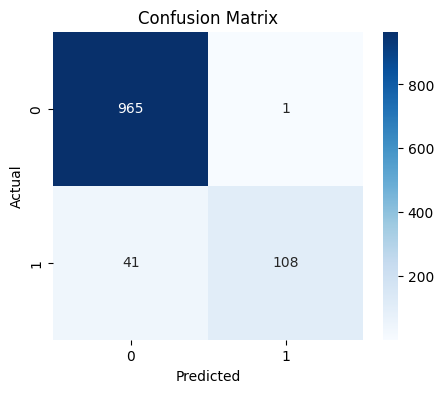

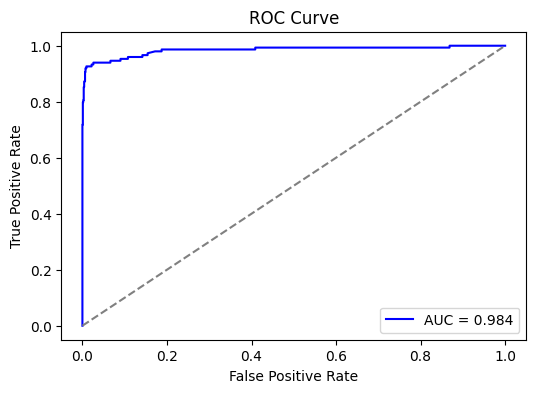

In [19]:
y_pred = model.predict(X_test_tfidf)
y_prob = model.predict_proba(X_test_tfidf)[:, 1]

print("\n Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print(" ROC-AUC Score:", round(roc_auc_score(y_test, y_prob), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

 #Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


#  ROC Curve

from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0,1], [0,1], '--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

Custom Prediction Function

In [20]:
def predict_message(msg):
    msg_clean = clean_text(msg)
    msg_vec = tfidf.transform([msg_clean])
    pred = model.predict(msg_vec)[0]
    return "🚨 Spam" if pred == 1 else " Ham (Not Spam)"

print("\nExample Predictions:")
print("1.", predict_message("Congratulations! You won a free lottery ticket!"))
print("2.", predict_message("Hey, are we still meeting for lunch today?"))



Example Predictions:
1. 🚨 Spam
2.  Ham (Not Spam)


 Save Model and Vectorizer

In [ ]:
joblib.dump(model, "sms_spam_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
print("\n Model and vectorizer saved successfully!")


✅ Model and vectorizer saved successfully!
